# Problem 1: The power of two choices

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from tqdm import tqdm
import torch
import hashlib
from sortedcontainers import SortedDict
from collections import Counter
import pandas as pd
from tabulate import tabulate

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [33]:
import numpy as np

def uniform_sample(m: int, n: int) -> int:
    bins = np.zeros(n)
    for _ in range(m):
        sample = np.random.randint(0, n)
        bins[sample] += 1
    return int(bins.max())

def two_bins_sample(m: int, n: int) -> int:
    bins = np.zeros(n)
    for _ in range(m):
        list1 = np.random.randint(0, n)
        list2 = np.random.randint(0, n)
        if bins[list1] < bins[list2]:
            bins[list1] += 1
        else:
            bins[list2] += 1
    return int(bins.max())

def three_bins_sample(m: int, n: int) -> int:
    bins = np.zeros(n)
    for _ in range(m):
        list1 = np.random.randint(0, n)
        list2 = np.random.randint(0, n)
        list3 = np.random.randint(0, n)
        if bins[list1] <= bins[list2] and bins[list1] <= bins[list3]:
            bins[list1] += 1
        elif bins[list2] <= bins[list1] and bins[list2] <= bins[list3]:
            bins[list2] += 1
        else:
            bins[list3] += 1
    return int(bins.max())

def next_sample(m: int, n: int) -> int:
    bins = np.zeros(n)
    for _ in range(m):
        index = np.random.randint(0, n)
        next_index = (index + 1) % n
        if bins[index] < bins[next_index]:
            bins[index] += 1
        else:
            bins[next_index] += 1
    return int(bins.max())

In [34]:
from tqdm import tqdm  # Import tqdm for progress bars

sample_size = 100
m = 1000000
n = 100000

print("doing uniform: ")
uniform_results = []
for _ in tqdm(range(sample_size)):
    uniform_results.append(uniform_sample(m, n))

print("doing two bins: ")
two_bins_results = []
for _ in tqdm(range(sample_size)):
    two_bins_results.append(two_bins_sample(m, n))

print("doing three bins: ")
three_bins_results = []
for _ in tqdm(range(sample_size)):
    three_bins_results.append(three_bins_sample(m, n))

print("doing next: ")
next_results = []
for _ in tqdm(range(sample_size)):
    next_results.append(next_sample(m, n))

doing uniform: 


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]


doing two bins: 


100%|██████████| 100/100 [04:20<00:00,  2.61s/it]


doing three bins: 


100%|██████████| 100/100 [06:23<00:00,  3.83s/it]


doing next: 


100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


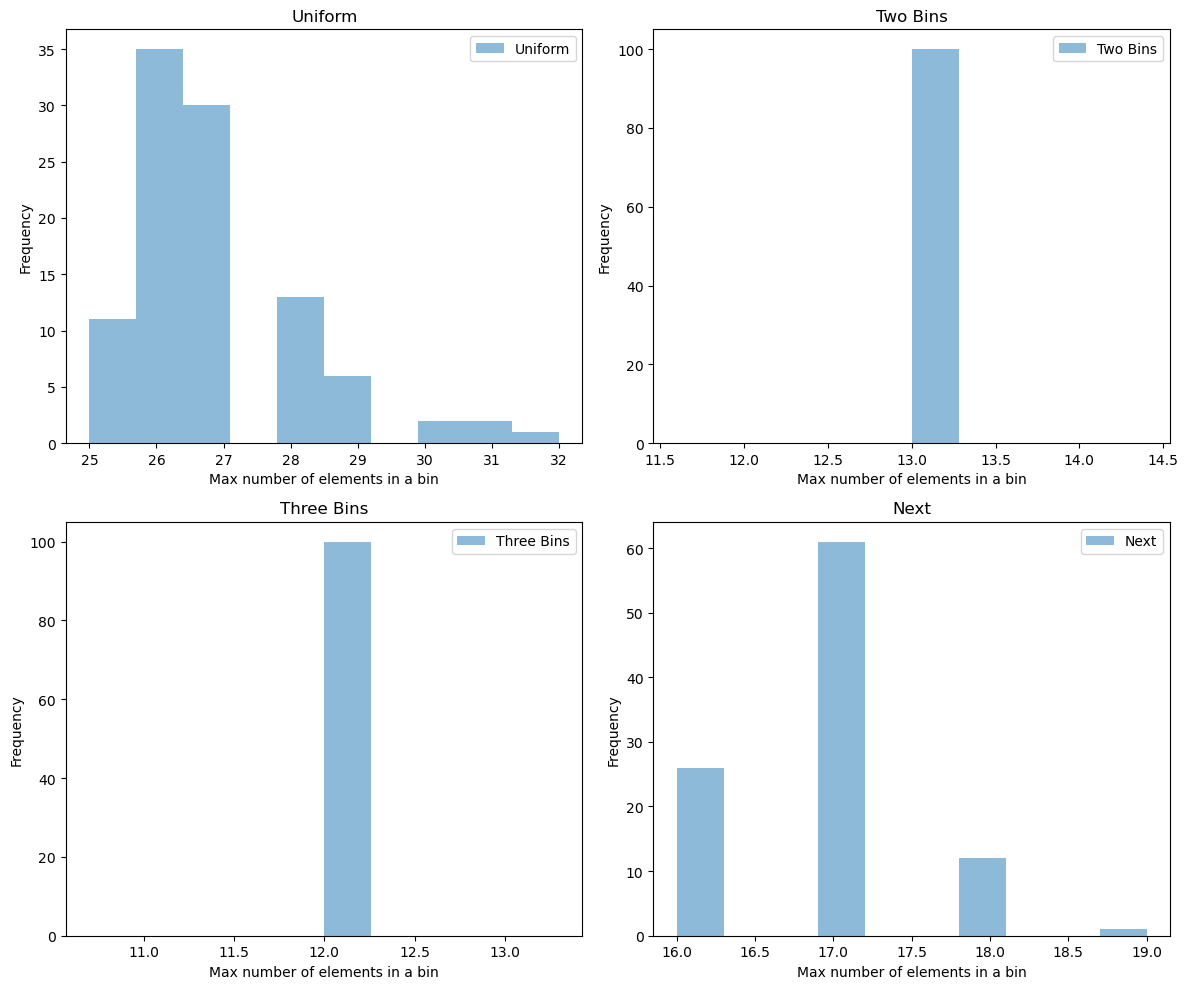

In [49]:
def plot():
    import numpy as np
    
    # Combine all plots into one figure
    plt.figure(figsize=(12, 10))
    
    # Function to determine bins
    def get_bins(data, num_bins=10):
        if len(set(data)) == 1:  # Constant data
            unique_value = data[0]
            # Create centered bins around the constant value
            half_bin_width = (unique_value + 1) / num_bins
            return np.linspace(unique_value - half_bin_width, unique_value + half_bin_width, num_bins + 1)
        return num_bins

    # Uniform Results
    plt.subplot(2, 2, 1)
    plt.hist(uniform_results, bins=get_bins(uniform_results), alpha=0.5, label='Uniform', align='mid')
    plt.xlabel('Max number of elements in a bin')
    plt.ylabel('Frequency')
    plt.title('Uniform')
    plt.legend()

    # Two Bins Results
    plt.subplot(2, 2, 2)
    plt.hist(two_bins_results, bins=get_bins(two_bins_results), alpha=0.5, label='Two Bins', align='mid')
    plt.xlabel('Max number of elements in a bin')
    plt.ylabel('Frequency')
    plt.title('Two Bins')
    plt.legend()

    # Three Bins Results
    plt.subplot(2, 2, 3)
    plt.hist(three_bins_results, bins=get_bins(three_bins_results), alpha=0.5, label='Three Bins', align='mid')
    plt.xlabel('Max number of elements in a bin')
    plt.ylabel('Frequency')
    plt.title('Three Bins')
    plt.legend()

    # Next Results
    plt.subplot(2, 2, 4)
    plt.hist(next_results, bins=get_bins(next_results), alpha=0.5, label='Next', align='mid')
    plt.xlabel('Max number of elements in a bin')
    plt.ylabel('Frequency')
    plt.title('Next')
    plt.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

    
plot()

# Problem 2: Count-min sketch


In [26]:
class CountMinSketch:
    def __init__(self, seed: int, n: int, eps: float):
        self.seed = seed
        self.b = 256  # Number of columns
        self.l = 6    # Number of hash functions (rows)
        self.n = n    # Number of elements
        self.eps = eps  # Epsilon for heavy hitters
        self.counts = np.zeros((self.l, self.b), dtype=int)  # 2D array for counts
        self.heavy_hitters = set()  # Set to track heavy hitters

    def hash(self, key: str) -> np.ndarray:
        """Hash a key using MD5 and return a NumPy array of hash values."""
        hash_val = hashlib.md5((key + str(self.seed)).encode('utf-8')).digest()
        return np.array([hash_val[i] % self.b for i in range(self.l)], dtype=int)

    def inc(self, key: str):
        """Increment the counts for the given key."""
        hashes = self.hash(key)  # Get hash values
        indices = np.arange(self.l)
        
        # for i,h in enumerate(hashes):
        #     self.counts[i,h] += 1
        
        # Find the minimum count across hash functions for the given key
        min_count = self.counts[indices, hashes].min()
        
        for i,h in enumerate(hashes):
            if self.counts[i,h] == min_count:
                self.counts[i,h] += 1

        # Check for heavy hitter
        if min_count >= self.eps * self.n:
            self.heavy_hitters.add(key)

    def count(self, key: str) -> int:
        """Return the estimated count of a key."""
        hashes = self.hash(key)  # Get hash values
        return self.counts[np.arange(self.l), hashes].min()  # Minimum count across hash functions


In [27]:
def generate_dataset(n: int):
    dataset = []
    # For i = 1 to n, add i (as a string) i^2 times
    for i in range(1, n + 1):
        dataset.extend([str(i)] * (i ** 2))
    # For i = n+1 to n^2, add i (as a string) once
    dataset.extend(map(str, range(n + 1, n**2 + 1)))
    return dataset

def count_min_sketch_experiment(dataset: list, seed: int):
    count_min_sketch = CountMinSketch(seed, len(dataset), 0.01)
    for key in dataset:
        count_min_sketch.inc(key)
    return count_min_sketch

In [28]:
n = 150

heavy_first_freq100 = np.zeros(10)
heavy_last_freq100 = np.zeros(10)
random_freq100 = np.zeros(10)

heavy_first_heavyhitters = np.zeros(10)
heavy_last_heavyhitters = np.zeros(10)
random_heavyhitters = np.zeros(10)

for i in tqdm(range(10)):
    dataset = generate_dataset(n)
    heavy_first = sorted(dataset, key=Counter(dataset).get, reverse=True)
    heavy_last = sorted(dataset, key=Counter(dataset).get)
    random_perm = np.random.permutation(dataset)
    
    count_heavy_first = count_min_sketch_experiment(heavy_first, i)
    count_heavy_last = count_min_sketch_experiment(heavy_last, i)
    count_random = count_min_sketch_experiment(random_perm, i)
    
    heavy_first_freq100[i] = count_heavy_first.count('100')
    heavy_last_freq100[i] = count_heavy_last.count('100')
    random_freq100[i] = count_random.count('100')
    
    heavy_first_heavyhitters[i] = len(count_heavy_first.heavy_hitters)
    heavy_last_heavyhitters[i] = len(count_heavy_last.heavy_hitters)
    random_heavyhitters[i] = len(count_random.heavy_hitters)

100%|██████████| 10/10 [03:05<00:00, 18.54s/it]


In [29]:
# Calculate averages and prepare the table
data = {
    "Category": ["Heavy First", "Heavy Last", "Random"],
    "Average Frequency of 100": [
        heavy_first_freq100.mean(),
        heavy_last_freq100.mean(),
        random_freq100.mean(),
    ],
    "Average Number of Heavy Hitters": [
        heavy_first_heavyhitters.mean(),
        heavy_last_heavyhitters.mean(),
        random_heavyhitters.mean(),
    ],
}

# Create a DataFrame for the table
df = pd.DataFrame(data)
# Convert to Markdown
markdown_table = tabulate(df, headers="keys", tablefmt="pipe", showindex=False, floatfmt=".2f")

# Save to a Markdown file
with open("table.md", "w") as f:
    f.write(markdown_table)

print("Markdown table saved to 'table.md'")

Markdown table saved to 'table.md'


Unoptimized Table:
| Category    |   Average Frequency of 100 |   Average Number of Heavy Hitters |
|:------------|---------------------------:|----------------------------------:|
| Heavy First |                   10082.00 |                             43.30 |
| Heavy Last  |                   10082.00 |                             43.00 |
| Random      |                   10082.00 |                             43.30 |

Optimized Table:
| Category    |   Average Frequency of 100 |   Average Number of Heavy Hitters |
|:------------|---------------------------:|----------------------------------:|
| Heavy First |                   10000.00 |                             43.20 |
| Heavy Last  |                   10033.80 |                             43.00 |
| Random      |                   10000.00 |                             43.00 |